# synApps soft scaler problem

*APS Training for Bluesky Data Acquisition*.

**Objective**

It appears the actual time the _soft_ scaler counts is longer than the preset time the scaler is configured to count by 0.1-0.2s.

1. Write a custom plan and collect some data to test this hypothesis.
2. Analyze the collected data.

In [1]:
from instrument.collection import *

I Thu-09:57:35 - /home/prjemian/Documents/projects/BCDA-APS/epics-bluesky-vm/instrument/iocs/check_iocs.py


Activating auto-logging. Current session state plus future input saved.
Filename       : /home/prjemian/Documents/projects/BCDA-APS/epics-bluesky-vm/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Thu-09:57:35 - EPICS IOCs ready...
I Thu-09:57:35 - #### Bluesky Framework ####
I Thu-09:57:35 - /home/prjemian/Documents/projects/BCDA-APS/epics-bluesky-vm/instrument/framework/check_python.py
I Thu-09:57:35 - /home/prjemian/Documents/projects/BCDA-APS/epics-bluesky-vm/instrument/framework/check_bluesky.py
I Thu-09:57:35 - /home/prjemian/Documents/projects/BCDA-APS/epics-bluesky-vm/instrument/framework/initialize.py
I Thu-09:57:36 - using databroker catalog 'training'
I Thu-09:57:36 - /home/prjemian/Documents/projects/BCDA-APS/epics-bluesky-vm/instrument/framework/metadata.py
I Thu-09:57:36 - #### Devices ####
I Thu-09:57:36 - /home/prjemian/Documents/projects/BCDA-APS/epics-bluesky-vm/instrument/devices/area_detector.py
I Thu-09:57:36 - /home/prjemian/Documents/projects/BCDA-APS/epics-bluesky-vm/instrument/devices/calculation_records.py
I Thu-09:57:38 - /home/prjemian/Documents/projects/BCDA-APS/epics-bluesky-vm/instrument/devices/ioc_stats.py
I Thu-09:57:38 - /home/prjemian/Docume

## Custom plan

Write a custom plan that collects the data.  Vary the count time across a range to determine if the actual count time is always between +0.1 to +0.2s larger than the preset time.  For each count time, collect $n$ measurements (default: 50).

Use one of the _userCalcs_ (`calcs.calc5` is available) to compute the difference in the preset and actual count times.

In [2]:
from ophyd import EpicsSignal

def data_collector(num_readings=50, time_short=0.1, time_long=.325, time_step=0.02):
    # create Signals to make the column names meaningful (and not generic)
    preset_time = EpicsSignal(scaler1.preset_time.pvname, name="preset_time")
    time_difference = EpicsSignal(calcs.calc5.calculated_value.pvname, name="count_difference")
    preset_time.wait_for_connection()
    time_difference.wait_for_connection()

    # setup the userCalc
    yield from bps.mv(
        calcs.calc5.channels.A.input_pv, scaler1.preset_time.pvname,
        calcs.calc5.channels.B.input_pv, scaler1.time.pvname,
        calcs.calc5.calculation, "B-A",
        calcs.calc5.scanning_rate, "I/O Intr",
        calcs.calc5.description, "scaler count time difference",
    )

    scaler1.select_channels(["timebase",])
    for i, count_time in enumerate(np.arange(time_short, time_long, time_step)):
        logger.info("Testing %.2f s soft scaler count time.", count_time)
        md = dict(
            count_time=count_time,
            notebook="softScalerCountTimeProblem",
            start_group=(i == 0),  # metadata flag to locate start of latest measurements
        )
        scaler1.stage_sigs["preset_time"] = count_time
        yield from bp.count([scaler1, preset_time, time_difference], num=num_readings, delay=0.05, md=md)
    scaler1.select_channels()
    del scaler1.stage_sigs["preset_time"]

Run the plan and gather all the run uids at the end to make it easier to reconstruct the data for analysis.  Short run to test the plan first.

I Thu-09:57:41 - Testing 0.15 s soft scaler count time.




Transient Scan ID: 120     Time: 2021-04-15 09:57:41
Persistent Unique Scan ID: '1ea0e1a6-1419-4e4d-8936-33044d1f7c75'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------------+-------------+
|   seq_num |       time |   timebase | count_difference | preset_time |
+-----------+------------+------------+------------------+-------------+
|         1 | 09:57:42.2 |    3000000 |          0.15000 |       0.150 |
|         2 | 09:57:42.7 |    3000000 |          0.15000 |       0.150 |
+-----------+------------+------------+------------------+-------------+
generator count ['1ea0e1a6'] (scan num: 120)


I Thu-09:57:43 - Testing 0.17 s soft scaler count time.




Transient Scan ID: 121     Time: 2021-04-15 09:57:43
Persistent Unique Scan ID: 'f7d0bfc7-1ad4-42f0-8b8e-1045b024410d'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------------+-------------+
|   seq_num |       time |   timebase | count_difference | preset_time |
+-----------+------------+------------+------------------+-------------+
|         1 | 09:57:43.9 |    3000000 |          0.12500 |       0.175 |
|         2 | 09:57:44.5 |    3000000 |          0.12500 |       0.175 |
+-----------+------------+------------+------------------+-------------+
generator count ['f7d0bfc7'] (scan num: 121)


I Thu-09:57:45 - Testing 0.20 s soft scaler count time.




Transient Scan ID: 122     Time: 2021-04-15 09:57:45
Persistent Unique Scan ID: 'f3e27d0c-0d30-4b67-ad29-60fd5f69e479'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------------+-------------+
|   seq_num |       time |   timebase | count_difference | preset_time |
+-----------+------------+------------+------------------+-------------+
|         1 | 09:57:45.6 |    2000000 |          0.00000 |       0.200 |
|         2 | 09:57:46.2 |    3000000 |          0.10000 |       0.200 |
+-----------+------------+------------+------------------+-------------+
generator count ['f3e27d0c'] (scan num: 122)


I Thu-09:57:46 - Testing 0.22 s soft scaler count time.




Transient Scan ID: 123     Time: 2021-04-15 09:57:46
Persistent Unique Scan ID: 'c1613aca-8aa6-445e-9767-7c7d8d16bd9d'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------------+-------------+
|   seq_num |       time |   timebase | count_difference | preset_time |
+-----------+------------+------------+------------------+-------------+
|         1 | 09:57:47.5 |    4000000 |          0.17500 |       0.225 |
|         2 | 09:57:48.2 |    4000000 |          0.17500 |       0.225 |
+-----------+------------+------------+------------------+-------------+
generator count ['c1613aca'] (scan num: 123)


I Thu-09:57:48 - Testing 0.25 s soft scaler count time.




Transient Scan ID: 124     Time: 2021-04-15 09:57:48
Persistent Unique Scan ID: '0cabb1ab-c8ad-45bb-b76f-bf32433275d2'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------------+-------------+
|   seq_num |       time |   timebase | count_difference | preset_time |
+-----------+------------+------------+------------------+-------------+
|         1 | 09:57:49.6 |    4000000 |          0.15000 |       0.250 |
|         2 | 09:57:50.2 |    4000000 |          0.15000 |       0.250 |
+-----------+------------+------------+------------------+-------------+
generator count ['0cabb1ab'] (scan num: 124)
runs = ('1ea0e1a6-1419-4e4d-8936-33044d1f7c75', 'f7d0bfc7-1ad4-42f0-8b8e-1045b024410d', 'f3e27d0c-0d30-4b67-ad29-60fd5f69e479', 'c1613aca-8aa6-445e-9767-7c7d8d16bd9d', '0cabb1ab-c8ad-45bb-b76f-bf32433275d2')


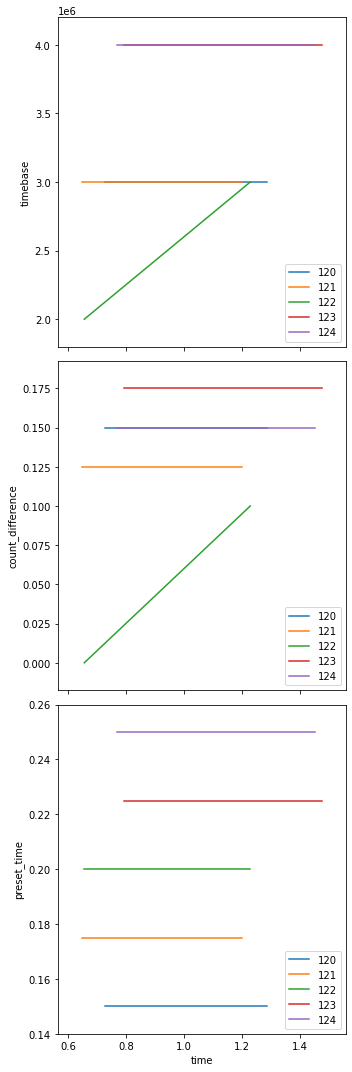

In [3]:
runs = RE(data_collector(num_readings=2, time_short=.15, time_long=.26, time_step=.025))
print(f"{runs = }")

Now, the full run with all default values, except 1,000 readings per count time (good statistics).

I Thu-09:57:51 - Testing 0.10 s soft scaler count time.




Transient Scan ID: 125     Time: 2021-04-15 09:57:51
Persistent Unique Scan ID: 'a6e12480-dad3-441a-a2f6-cb89e9e4637c'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------------+-------------+
|   seq_num |       time |   timebase | count_difference | preset_time |
+-----------+------------+------------+------------------+-------------+
|         1 | 09:57:51.7 |    1000000 |          0.00000 |       0.100 |
|         2 | 09:57:52.1 |    2000000 |          0.10000 |       0.100 |
|         3 | 09:57:52.5 |    1000000 |          0.00000 |       0.100 |
|         4 | 09:57:52.9 |    2000000 |          0.10000 |       0.100 |
|         5 | 09:57:53.4 |    2000000 |          0.10000 |       0.100 |
|         6 | 09:57:53.9 |    2000000 |          0.10000 |       0.100 |
|         7 | 09:57:54.4 |    2000000 |          0.10000 |       0.100 |
|         8 | 09:57:54.8 |    2000000 |          0.10000 |       0.100 |
|         9 | 09:57:55.1 |    1

I Thu-10:05:18 - Testing 0.12 s soft scaler count time.




Transient Scan ID: 126     Time: 2021-04-15 10:05:18
Persistent Unique Scan ID: '29d2e29c-1541-47f3-ad31-73a6a3409d73'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------------+-------------+
|   seq_num |       time |   timebase | count_difference | preset_time |
+-----------+------------+------------+------------------+-------------+
|         1 | 10:05:19.0 |    3000000 |          0.18000 |       0.120 |
|         2 | 10:05:19.6 |    3000000 |          0.18000 |       0.120 |
|         3 | 10:05:20.1 |    3000000 |          0.18000 |       0.120 |
|         4 | 10:05:20.7 |    3000000 |          0.18000 |       0.120 |
|         5 | 10:05:21.4 |    3000000 |          0.18000 |       0.120 |
|         6 | 10:05:21.9 |    3000000 |          0.18000 |       0.120 |
|         7 | 10:05:22.5 |    3000000 |          0.18000 |       0.120 |
|         8 | 10:05:23.1 |    3000000 |          0.18000 |       0.120 |
|         9 | 10:05:23.6 |    3

I Thu-10:14:58 - Testing 0.14 s soft scaler count time.




Transient Scan ID: 127     Time: 2021-04-15 10:14:58
Persistent Unique Scan ID: '61af291e-7df9-411d-9717-a795555898ff'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------------+-------------+
|   seq_num |       time |   timebase | count_difference | preset_time |
+-----------+------------+------------+------------------+-------------+
|         1 | 10:14:59.4 |    3000000 |          0.16000 |       0.140 |
|         2 | 10:14:59.9 |    3000000 |          0.16000 |       0.140 |
|         3 | 10:15:00.7 |    3000000 |          0.16000 |       0.140 |
|         4 | 10:15:01.3 |    3000000 |          0.16000 |       0.140 |
|         5 | 10:15:01.9 |    3000000 |          0.16000 |       0.140 |
|         6 | 10:15:02.6 |    3000000 |          0.16000 |       0.140 |
|         7 | 10:15:03.2 |    3000000 |          0.16000 |       0.140 |
|         8 | 10:15:03.8 |    2000000 |          0.06000 |       0.140 |
|         9 | 10:15:04.4 |    3

I Thu-10:25:03 - Testing 0.16 s soft scaler count time.




Transient Scan ID: 128     Time: 2021-04-15 10:25:03
Persistent Unique Scan ID: 'a34c43dc-64f6-42ca-aaaf-acf686ce47ce'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------------+-------------+
|   seq_num |       time |   timebase | count_difference | preset_time |
+-----------+------------+------------+------------------+-------------+
|         1 | 10:25:04.5 |    3000000 |          0.14000 |       0.160 |
|         2 | 10:25:05.1 |    3000000 |          0.14000 |       0.160 |
|         3 | 10:25:05.7 |    3000000 |          0.14000 |       0.160 |
|         4 | 10:25:06.4 |    3000000 |          0.14000 |       0.160 |
|         5 | 10:25:07.0 |    3000000 |          0.14000 |       0.160 |
|         6 | 10:25:07.6 |    3000000 |          0.14000 |       0.160 |
|         7 | 10:25:08.3 |    3000000 |          0.14000 |       0.160 |
|         8 | 10:25:09.0 |    3000000 |          0.14000 |       0.160 |
|         9 | 10:25:09.6 |    3

I Thu-10:35:33 - Testing 0.18 s soft scaler count time.




Transient Scan ID: 129     Time: 2021-04-15 10:35:33
Persistent Unique Scan ID: 'a2b593f1-a1de-4e24-b919-1bc7dd499fc9'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------------+-------------+
|   seq_num |       time |   timebase | count_difference | preset_time |
+-----------+------------+------------+------------------+-------------+
|         1 | 10:35:34.3 |    3000000 |          0.12000 |       0.180 |
|         2 | 10:35:34.9 |    3000000 |          0.12000 |       0.180 |
|         3 | 10:35:35.6 |    3000000 |          0.12000 |       0.180 |
|         4 | 10:35:36.2 |    3000000 |          0.12000 |       0.180 |
|         5 | 10:35:36.9 |    3000000 |          0.12000 |       0.180 |
|         6 | 10:35:37.7 |    3000000 |          0.12000 |       0.180 |
|         7 | 10:35:38.3 |    3000000 |          0.12000 |       0.180 |
|         8 | 10:35:39.0 |    3000000 |          0.12000 |       0.180 |
|         9 | 10:35:39.6 |    3

I Thu-10:46:45 - Testing 0.20 s soft scaler count time.




Transient Scan ID: 130     Time: 2021-04-15 10:46:45
Persistent Unique Scan ID: '95f6c81e-ffc4-468a-bbc7-bcd7d78c2c56'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------------+-------------+
|   seq_num |       time |   timebase | count_difference | preset_time |
+-----------+------------+------------+------------------+-------------+
|         1 | 10:46:46.6 |    3000000 |          0.10000 |       0.200 |
|         2 | 10:46:47.2 |    3000000 |          0.10000 |       0.200 |
|         3 | 10:46:47.9 |    3000000 |          0.10000 |       0.200 |
|         4 | 10:46:48.6 |    3000000 |          0.10000 |       0.200 |
|         5 | 10:46:49.3 |    3000000 |          0.10000 |       0.200 |
|         6 | 10:46:50.0 |    3000000 |          0.10000 |       0.200 |
|         7 | 10:46:50.7 |    3000000 |          0.10000 |       0.200 |
|         8 | 10:46:51.4 |    3000000 |          0.10000 |       0.200 |
|         9 | 10:46:52.0 |    3

I Thu-10:58:23 - Testing 0.22 s soft scaler count time.




Transient Scan ID: 131     Time: 2021-04-15 10:58:23
Persistent Unique Scan ID: '90f2f19c-e5cc-48e2-8090-18a50f5ff483'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------------+-------------+
|   seq_num |       time |   timebase | count_difference | preset_time |
+-----------+------------+------------+------------------+-------------+
|         1 | 10:58:23.9 |    4000000 |          0.18000 |       0.220 |
|         2 | 10:58:24.7 |    4000000 |          0.18000 |       0.220 |
|         3 | 10:58:25.7 |    4000000 |          0.18000 |       0.220 |
|         4 | 10:58:26.5 |    3000000 |          0.08000 |       0.220 |
|         5 | 10:58:27.3 |    4000000 |          0.18000 |       0.220 |
|         6 | 10:58:28.1 |    4000000 |          0.18000 |       0.220 |
|         7 | 10:58:28.9 |    4000000 |          0.18000 |       0.220 |
|         8 | 10:58:29.9 |    4000000 |          0.18000 |       0.220 |
|         9 | 10:58:30.7 |    4

I Thu-11:12:13 - Testing 0.24 s soft scaler count time.




Transient Scan ID: 132     Time: 2021-04-15 11:12:13
Persistent Unique Scan ID: '5e538711-c3a5-4ee2-b896-5623f5bf77fc'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------------+-------------+
|   seq_num |       time |   timebase | count_difference | preset_time |
+-----------+------------+------------+------------------+-------------+
|         1 | 11:12:13.8 |    4000000 |          0.16000 |       0.240 |
|         2 | 11:12:14.6 |    4000000 |          0.16000 |       0.240 |
|         3 | 11:12:15.5 |    4000000 |          0.16000 |       0.240 |
|         4 | 11:12:16.3 |    4000000 |          0.16000 |       0.240 |
|         5 | 11:12:17.0 |    4000000 |          0.16000 |       0.240 |
|         6 | 11:12:17.8 |    4000000 |          0.16000 |       0.240 |
|         7 | 11:12:18.6 |    4000000 |          0.16000 |       0.240 |
|         8 | 11:12:19.4 |    4000000 |          0.16000 |       0.240 |
|         9 | 11:12:20.2 |    4

I Thu-11:25:36 - Testing 0.26 s soft scaler count time.




Transient Scan ID: 133     Time: 2021-04-15 11:25:36
Persistent Unique Scan ID: '88393096-22d4-4905-87bd-16dafb43a94f'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------------+-------------+
|   seq_num |       time |   timebase | count_difference | preset_time |
+-----------+------------+------------+------------------+-------------+
|         1 | 11:25:37.2 |    4000000 |          0.14000 |       0.260 |
|         2 | 11:25:38.0 |    4000000 |          0.14000 |       0.260 |
|         3 | 11:25:38.8 |    4000000 |          0.14000 |       0.260 |
|         4 | 11:25:39.6 |    4000000 |          0.14000 |       0.260 |
|         5 | 11:25:40.6 |    4000000 |          0.14000 |       0.260 |
|         6 | 11:25:41.4 |    4000000 |          0.14000 |       0.260 |
|         7 | 11:25:42.2 |    4000000 |          0.14000 |       0.260 |
|         8 | 11:25:43.2 |    4000000 |          0.14000 |       0.260 |
|         9 | 11:25:44.0 |    4

I Thu-11:39:37 - Testing 0.28 s soft scaler count time.




Transient Scan ID: 134     Time: 2021-04-15 11:39:37
Persistent Unique Scan ID: '44047d91-3bd9-4f67-b828-09342bf8bf0b'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------------+-------------+
|   seq_num |       time |   timebase | count_difference | preset_time |
+-----------+------------+------------+------------------+-------------+
|         1 | 11:39:38.2 |    3000000 |          0.02000 |       0.280 |
|         2 | 11:39:39.0 |    4000000 |          0.12000 |       0.280 |
|         3 | 11:39:39.9 |    4000000 |          0.12000 |       0.280 |
|         4 | 11:39:40.7 |    4000000 |          0.12000 |       0.280 |
|         5 | 11:39:41.6 |    4000000 |          0.12000 |       0.280 |
|         6 | 11:39:42.4 |    4000000 |          0.12000 |       0.280 |
|         7 | 11:39:43.3 |    4000000 |          0.12000 |       0.280 |
|         8 | 11:39:44.1 |    4000000 |          0.12000 |       0.280 |
|         9 | 11:39:45.0 |    4

I Thu-11:54:02 - Testing 0.30 s soft scaler count time.




Transient Scan ID: 135     Time: 2021-04-15 11:54:02
Persistent Unique Scan ID: 'bb1940c3-bea3-4120-b817-f5a0b30d3c03'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------------+-------------+
|   seq_num |       time |   timebase | count_difference | preset_time |
+-----------+------------+------------+------------------+-------------+
|         1 | 11:54:03.5 |    4000000 |          0.10000 |       0.300 |
|         2 | 11:54:04.4 |    4000000 |          0.10000 |       0.300 |
|         3 | 11:54:05.3 |    4000000 |          0.10000 |       0.300 |
|         4 | 11:54:06.2 |    4000000 |          0.10000 |       0.300 |
|         5 | 11:54:07.1 |    4000000 |          0.10000 |       0.300 |
|         6 | 11:54:07.9 |    4000000 |          0.10000 |       0.300 |
|         7 | 11:54:08.8 |    4000000 |          0.10000 |       0.300 |
|         8 | 11:54:09.7 |    4000000 |          0.10000 |       0.300 |
|         9 | 11:54:10.5 |    4

I Thu-12:08:44 - Testing 0.32 s soft scaler count time.




Transient Scan ID: 136     Time: 2021-04-15 12:08:44
Persistent Unique Scan ID: 'ebb2fe1b-4e46-4daa-b50d-856bab1ef172'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------------+-------------+
|   seq_num |       time |   timebase | count_difference | preset_time |
+-----------+------------+------------+------------------+-------------+
|         1 | 12:08:45.3 |    5000000 |          0.18000 |       0.320 |
|         2 | 12:08:46.3 |    5000000 |          0.18000 |       0.320 |
|         3 | 12:08:47.5 |    5000000 |          0.18000 |       0.320 |
|         4 | 12:08:48.5 |    5000000 |          0.18000 |       0.320 |
|         5 | 12:08:49.5 |    5000000 |          0.18000 |       0.320 |
|         6 | 12:08:50.5 |    5000000 |          0.18000 |       0.320 |
|         7 | 12:08:51.5 |    5000000 |          0.18000 |       0.320 |
|         8 | 12:08:52.6 |    5000000 |          0.18000 |       0.320 |
|         9 | 12:08:53.6 |    5

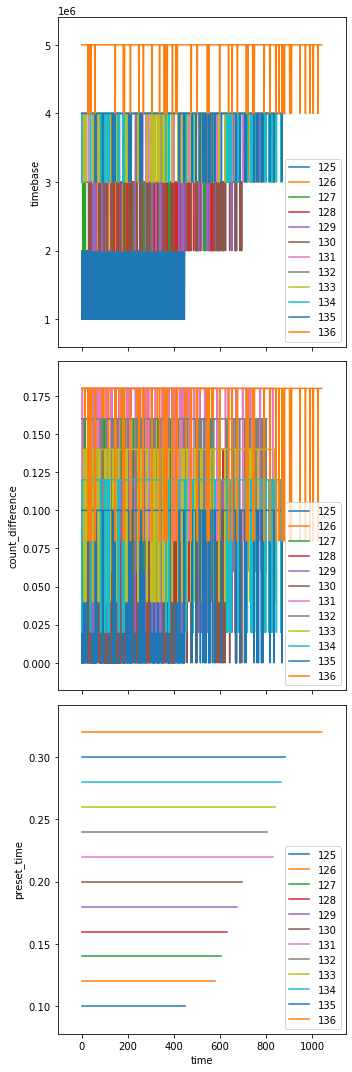

In [4]:
runs = RE(data_collector(num_readings=1_000))
print(f"{runs = }")

## Analyze the collected data

In [33]:
db.v2[-1].primary.read()["count_difference"].mean().to_dict()["data"]

0.17559999999999992

In [39]:
import pyRestTable
tbl = pyRestTable.Table()
tbl.labels = "scan_id preset_time <actual> <difference> +/-".split()
for uid in runs:
    run = db.v2[uid]
    md = run.metadata
    a = run.primary.read()["scaler1_time"]
    d = run.primary.read()["count_difference"]
    tbl.addRow(
        (
            md['start']['scan_id'],
            f"{md['start']['count_time']:.04f}",
            f"{a.mean().to_dict()['data']:.04f}",
            f"{d.mean().to_dict()['data']:.04f}",
            f"{d.std().to_dict()['data']:.04f}",
        )
    )
print(tbl)

======= =========== ======== ============ ======
scan_id preset_time <actual> <difference> +/-   
======= =========== ======== ============ ======
125     0.1000      0.1731   0.0731       0.0443
126     0.1200      0.2957   0.1757       0.0203
127     0.1400      0.2949   0.1549       0.0220
128     0.1600      0.2958   0.1358       0.0201
129     0.1800      0.2960   0.1160       0.0196
130     0.2000      0.2958   0.0958       0.0201
131     0.2200      0.3946   0.1746       0.0226
132     0.2400      0.3952   0.1552       0.0214
133     0.2600      0.3947   0.1347       0.0224
134     0.2800      0.3957   0.1157       0.0203
135     0.3000      0.3962   0.0962       0.0191
136     0.3200      0.4956   0.1756       0.0205
======= =========== ======== ============ ======

